# In this notebook: 

- Upload and clean data
- Split train/validation
- TF-IDF
- Baseline models (LogReg, SVM, Naive Bayes)
- Final comparison
- Save best model

In [1]:
import pandas as pd
from pathlib import Path

import re
import contractions
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords_en = set(ENGLISH_STOP_WORDS)

DATA_RAW = Path("../data/raw")
TRAIN_PATH = DATA_RAW / "train.ft.txt.bz2"

print("Train exists:", TRAIN_PATH.exists())

Train exists: True


In [2]:
# clean text (as in notebook 01_eda_reviews.ipynb)
def clean_text(text):
    text = contractions.fix(text)         # don't → do not
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)  # remove punctuation
    text = re.sub(r"\b\d+\b", " ", text)  # remove numbers
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stopwords(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_en and len(t) > 1]
    return " ".join(tokens)

In [3]:
import bz2

def load_ft_dataset(path, max_rows=None):
    texts = []
    labels = []
    with bz2.open(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            try:
                label, text = line.split(" ", 1)
            except ValueError:
                continue
            labels.append(label.replace("__label__", "").strip())
            texts.append(text.strip())
    return pd.DataFrame({"label": labels, "text": texts})

In [4]:
# upload data
df = load_ft_dataset(TRAIN_PATH, max_rows=50000)

df["clean_text"] = df["text"].apply(clean_text)
df["clean_text_no_stop"] = df["clean_text"].apply(remove_stopwords)

# save
df.to_csv('../data/processed/train_preprocessed.csv')

df.head()

,label,text,clean_text,clean_text_no_stop
0,2,Stuning even for the non-gamer: This sound tra...,stuning even for the non gamer this sound trac...,stuning non gamer sound track beautiful paints...
1,2,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything i am read...,best soundtrack reading lot reviews saying bes...
2,2,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...,amazing soundtrack favorite music time hands i...
3,2,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...,excellent soundtrack truly like soundtrack enj...
4,2,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...,remember pull jaw floor hearing played game kn...


# pre- modeling:
- Split sample (train/val)
- Create TF-IDF matrix
- prepare variables 

In [5]:
from sklearn.model_selection import train_test_split

# Splt sample 
X = df["clean_text_no_stop"].values
y = df["label"].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_val)

(40000, 10000)

In [6]:
# Create TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,     # n_features
    ngram_range=(1, 2),     # unigrams + bigrams
    min_df=5,               # remove palavras raras
    sublinear_tf=True       # TF sublinear melhora LR/SVM
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape

((40000, 42733), (10000, 42733))

In [7]:
# show some features:
tfidf.get_feature_names_out()[:20]

array(['100x', '1080p', '10th', '10th grade', '10x', '11th', '11th grade',
       '128mb', '12th', '13th', '15th', '16mm', '16th', '16x9', '17th',
       '17th century', '1800s', '18th', '18th century', '1900s'],
      dtype=object)

# Let's repeat logistic regression as in notebook 01_eda_reviews

In [8]:
# train model
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(
    max_iter=200,
    n_jobs=-1,
    C=2.0,
)

clf_lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=2.0, max_iter=200, n_jobs=-1)

In [9]:
# Predict & metrics
from sklearn.metrics import accuracy_score, classification_report

y_pred_lr = clf_lr.predict(X_val_tfidf)

acc_lr = accuracy_score(y_val, y_pred_lr)
print(f"Logistic Regression - Validation Accuracy: {acc_lr:.4f}\n")

print("Classification report (Logistic Regression):")
print(classification_report(y_val, y_pred_lr, digits=4))

Logistic Regression - Validation Accuracy: 0.8906

Classification report (Logistic Regression):
              precision    recall  f1-score   support

           1     0.8948    0.8802    0.8874      4899
           2     0.8867    0.9006    0.8936      5101

    accuracy                         0.8906     10000
   macro avg     0.8907    0.8904    0.8905     10000
weighted avg     0.8907    0.8906    0.8906     10000



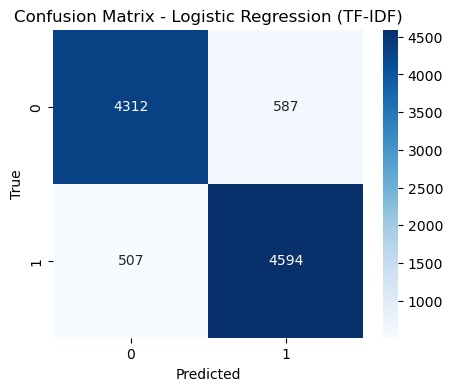

In [10]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_lr = confusion_matrix(y_val, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
# save result
results = {}
results["logreg"] = {
    "accuracy": acc_lr,
    "cm": cm_lr,
}
results

{'logreg': {'accuracy': 0.8906,
  'cm': array([[4312,  587],
         [ 507, 4594]])}}

# Cool! Nice results. 
# Now, let's test the SVM...

In [12]:
from sklearn.svm import LinearSVC

clf_svm = LinearSVC(
    C=0.25,         # regularização (podemos tunar depois)
)

clf_svm.fit(X_train_tfidf, y_train)

/home/mcvicentin/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=0.25)

In [13]:
y_pred_svm = clf_svm.predict(X_val_tfidf)

from sklearn.metrics import accuracy_score, classification_report

acc_svm = accuracy_score(y_val, y_pred_svm)
print(f"Linear SVM - Validation Accuracy: {acc_svm:.4f}\n")

print("Classification report (Linear SVM):")
print(classification_report(y_val, y_pred_svm, digits=4))

Linear SVM - Validation Accuracy: 0.8927

Classification report (Linear SVM):
              precision    recall  f1-score   support

           1     0.8974    0.8818    0.8895      4899
           2     0.8884    0.9032    0.8957      5101

    accuracy                         0.8927     10000
   macro avg     0.8929    0.8925    0.8926     10000
weighted avg     0.8928    0.8927    0.8927     10000



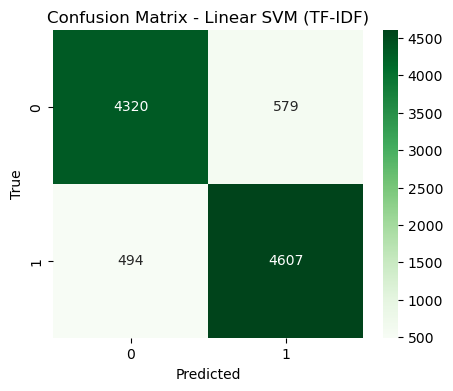

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(y_val, y_pred_svm)

plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Linear SVM (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Logistic reg vs SVM: Similar results!

# Let's try one more: Multinomial naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.3)   # alpha pode ser tunado depois
clf_nb.fit(X_train_tfidf, y_train)

y_pred_nb = clf_nb.predict(X_val_tfidf)

In [16]:
acc_nb = accuracy_score(y_val, y_pred_nb)
print(f"Naive Bayes - Validation Accuracy: {acc_nb:.4f}\n")

print("Classification report (Naive Bayes):")
print(classification_report(y_val, y_pred_nb, digits=4))

Naive Bayes - Validation Accuracy: 0.8718

Classification report (Naive Bayes):
              precision    recall  f1-score   support

           1     0.8708    0.8669    0.8689      4899
           2     0.8727    0.8765    0.8746      5101

    accuracy                         0.8718     10000
   macro avg     0.8718    0.8717    0.8717     10000
weighted avg     0.8718    0.8718    0.8718     10000



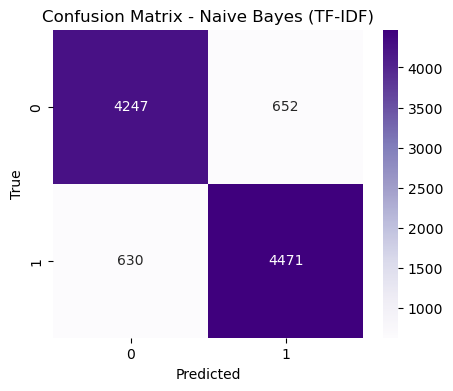

In [17]:
cm_nb = confusion_matrix(y_val, y_pred_nb)

plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Naive Bayes (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# OK! Results are similar between thse models. 
# Let's try more sophisticated models now...

In [18]:
# Setup DistilBERT

# Imports & Label mapping
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2025-11-21 11:49:31.567591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Torch version: 2.5.0+cu124
CUDA available: False


/home/mcvicentin/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [19]:
# change labels from {1,2} to {0,1} -> for HuggingFace
df_bert = df[["clean_text_no_stop", "label"]].copy()

# convert labels to integers
df_bert["label"] = df_bert["label"].astype(int)

label_map = {1: 0, 2: 1}   # 0 = negative, 1 = positive
df_bert["label_id"] = df_bert["label"].map(label_map)

df_bert["label_id"].value_counts()

label_id
1    25506
0    24494
Name: count, dtype: int64

In [20]:
# Prepara dados p BERT
N_BERT = 40000  # pode aumentar depois se estiver tranquilo

df_bert_small = df_bert.sample(n=N_BERT, random_state=42).reset_index(drop=True)
df_bert_small.head()
len(df_bert_small)

40000

In [21]:
# Split sample
train_df_bert, val_df_bert = train_test_split(
    df_bert_small,
    test_size=0.2,
    random_state=42,
    stratify=df_bert_small["label_id"],
)

len(train_df_bert), len(val_df_bert)

(32000, 8000)

In [22]:
# carrega tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Next, we transform the DF in a HuggingFace dataset compatible with the Trainer.

In [23]:
# class: receive tokenizer; tokenize ceach text; return  input_ids, attention_mask and labels
class BertReviewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text   = self.texts[idx]
        label  = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }
        return item

In [24]:
# Prepare training sample
train_dataset = BertReviewsDataset(
    train_df_bert["clean_text_no_stop"].tolist(),
    train_df_bert["label_id"].tolist(),
    tokenizer,
    max_len=128
)

val_dataset = BertReviewsDataset(
    val_df_bert["clean_text_no_stop"].tolist(),
    val_df_bert["label_id"].tolist(),
    tokenizer,
    max_len=128
)

In [25]:
# upload base model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# training arguments
training_args = TrainingArguments(
    output_dir="./bert_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,  # deixa mais leve em CPU
    per_device_eval_batch_size=8,
    num_train_epochs=3,             #  ← aumenta para 3
    learning_rate=3e-5,             #  ← LR mais forte
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
)

/home/mcvicentin/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [27]:
# compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    
    preds = np.argmax(logits, axis=1)
    
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [28]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,   
)

/tmp/ipykernel_12068/2229257191.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# treina
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
eval_results = trainer.evaluate()
eval_results

In [ ]:
# save all artifacts

# ============================================================
# SAVE MODELS FOR THE API
# ============================================================

import os
import pickle

SAVE_DIR = "../models/sentiment/classic"
os.makedirs(SAVE_DIR, exist_ok=True)

TFIDF_PATH = os.path.join(SAVE_DIR, "tfidf.pkl")
LOGREG_PATH = os.path.join(SAVE_DIR, "logreg.pkl")
SVM_PATH = os.path.join(SAVE_DIR, "svm.pkl")
NB_PATH = os.path.join(SAVE_DIR, "nb.pkl")

print("Saving TF-IDF vectorizer...")
with open(TFIDF_PATH, "wb") as f:
    pickle.dump(tfidf, f)

print("Saving Logistic Regression model...")
with open(LOGREG_PATH, "wb") as f:
    pickle.dump(clf_lr, f)

print("Saving Linear SVM model...")
with open(SVM_PATH, "wb") as f:
    pickle.dump(clf_svm, f)

print("Saving Naive Bayes model...")
with open(NB_PATH, "wb") as f:
    pickle.dump(clf_nb, f)

print("\n=== All artifacts saved successfully! ===")
print(f"Directory: {SAVE_DIR}")


# Classical models shown good initial performance, and a more modern one--DistilBERT--shown similar results, but with good potential to improve, giving the limited computational resources. We will test it again later in a GPU environment with full dataset.